In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from lmfit import minimize, Parameters, Parameter, report_fit
import matplotlib.pyplot as plt; plt.rc('font', size=16)

In [2]:
params_ex = {'growth': np.array([3.5, 3.3, 4]), 'cross_int': np.array([[-1.2, 6, -4], [-5, -1.5, 4], [5, -5.5, -2]])}
x0_ex = np.array([0.5, 0.5, 0.5])
t_span_ex = [0, 10]
t_ex = np.linspace(t_span_ex[0], t_span_ex[1], 100)

def define_params(params=params_ex):
    p = Parameters()
    p.add('species', value=len(params['growth']), vary=False)
    for key, value in params.items():
        if key == 'growth':
            for i in range(len(value)):
                p.add(f'growth_{i+1}', value=value[i], min=0, vary=True)
        elif key == 'cross_int':
            for i in range(len(value)):
                for j in range(len(value)):
                    if i == j:
                        p.add(f'cross_int_{i+1}_{j+1}', value=value[i, j], max=0, vary=True)
                    else:
                        p.add(f'cross_int_{i+1}_{j+1}', value=value[i, j], vary=True)
    return p
params = define_params()
params

name,value,initial value,min,max,vary
species,3.00000000,3,-inf,inf,False
growth_1,3.50000000,3.5,0.00000000,inf,True
growth_2,3.30000000,3.3,0.00000000,inf,True
growth_3,4.00000000,4.0,0.00000000,inf,True
cross_int_1_1,-1.20000000,-1.2,-inf,0.00000000,True
cross_int_1_2,6.00000000,6.0,-inf,inf,True
cross_int_1_3,-4.00000000,-4.0,-inf,inf,True
cross_int_2_1,-5.00000000,-5.0,-inf,inf,True
cross_int_2_2,-1.50000000,-1.5,-inf,0.00000000,True
cross_int_2_3,4.00000000,4.0,-inf,inf,True


In [4]:
def gLV(x, t, params):
    growth = np.array([params[f'growth_{i+1}'].value for i in range(params['species'].value)])
    cross_int = np.array([[params[f'cross_int_{i+1}_{j+1}'].value for i in range(params['species'].value)] for j in range(params['species'].value)])

    inter = np.sum([x[i]*cross_int[i,j] for i in range(len(x)) for j in range(len(x))])

    return np.array([x[i]*(growth[i] + inter) for i in range(len(x))])

def solve_gLV(model=gLV, t_span=t_span_ex, x0=x0_ex, params=params, t_eval=t_ex):
    return solve_ivp(lambda t, x: model(x, t, params), t_span, x0, t_eval=t_eval)

def residuals(params, t, data):
    model = solve_gLV(params=params)
    return model.y - data

def fit_gLV(data, t, params=params):
    out = minimize(residuals, params, args=(t, data))
    return out

In [5]:
sol = solve_gLV()
sol


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 116
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.656565

In [6]:
test_data = sol.y + np.random.normal(size=sol.y.shape)*0.1
test_t = sol.t

In [7]:
result = fit_gLV(test_data, test_t)
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 117
    # data points      = 300
    # variables        = 12
    chi-square         = 2.94898944
    reduced chi-square = 0.01023955
    Akaike info crit   = -1362.69598
    Bayesian info crit = -1318.25059
[[Variables]]
    species:        3 (fixed)
    growth_1:       3.46195619 +/- 1.05772153 (30.55%) (init = 3.5)
    growth_2:       3.26745569 +/- 1.05693159 (32.35%) (init = 3.3)
    growth_3:       3.95829415 +/- 1.05706964 (26.71%) (init = 4)
    cross_int_1_1: -0.78568146 +/- 114796.846 (14611118.12%) (init = -1.2)
    cross_int_1_2:  5.54703899 +/- 295337.752 (5324241.50%) (init = 6)
    cross_int_1_3: -4.00624494 +/- 420145.832 (10487272.69%) (init = -4)
    cross_int_2_1: -4.57999110 +/- 313864.899 (6852958.72%) (init = -5)
    cross_int_2_2: -1.98737052 +/- 146277.354 (7360346.35%) (init = -1.5)
    cross_int_2_3:  3.99380182 +/- 267211.999 (6690667.47%) (init = 4)
    cross_int_3_1:  5.42728360 +/-

In [8]:
final = test_data + result.residual.reshape(test_data.shape)

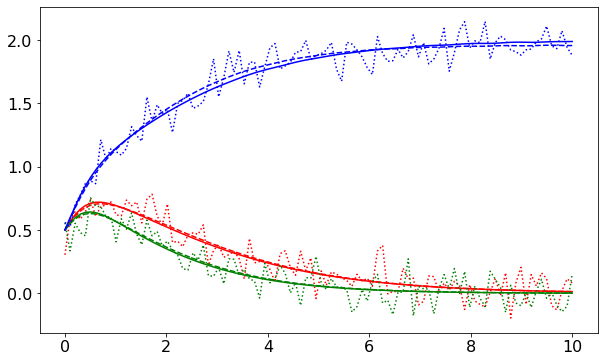

In [9]:
col = ['r', 'g', 'b']
plt.figure(figsize=(10, 6))
for i in range(len(col)):
    plt.plot(sol.t, sol.y[i], color=col[i])
    plt.plot(test_t, test_data[i], color=col[i], linestyle=':')
    plt.plot(test_t, final[i], color=col[i], linestyle='--')
plt.show()